# Text-to-Speech with Tacotron2
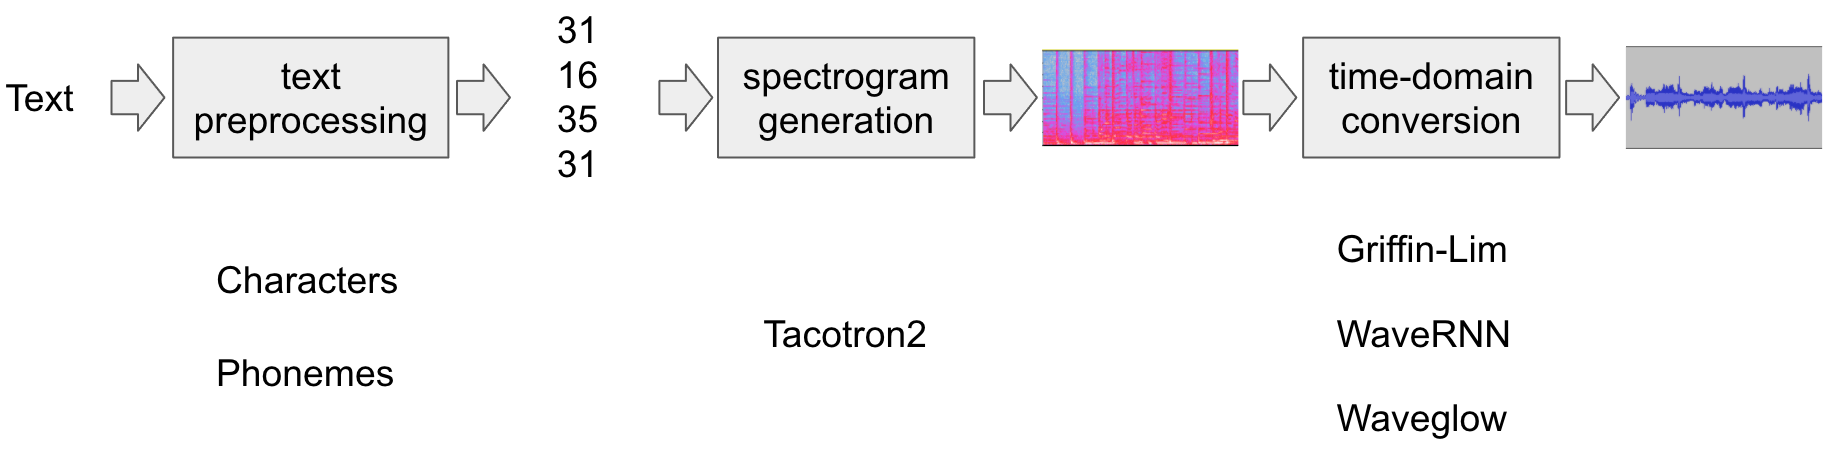

In [1]:
!pip install deep_phonemizer

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33288 sha256=efed7f7b5f17b2ffe1ed795a030ec81dcbd33ea8ad5999cab5d6b6b2cb0f2d43
  Stored in directory: c:\users\hopio\appdata\local\pip\cache\wheels\b9\d7\45\f2ae07184a29327b2a7f93b1f734a936c3a34e57225fca603b
Successfully built deep_phonemizer


In [1]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.3.1
2.3.1
cuda


In [2]:
import IPython
import matplotlib.pyplot as plt

In [3]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [4]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [5]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


In [6]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


c:\Users\hopio\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


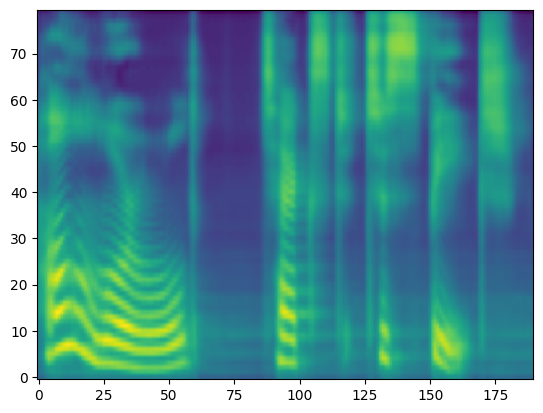

In [8]:
import torchaudio
import torch
import matplotlib.pyplot as plt

# Tacotron2와 WaveRNN의 파이프라인
# TACOTRON2_WAVERNN_PHONE_LJSPEECH는 텍스트-음성 변환을 위한 모델 파이프라인
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

# 텍스트를 처리하기 위한 텍스트 프로세서
processor = bundle.get_text_processor()

# Tacotron2 모델을 가져와서 선택한 장치 (CPU 또는 GPU)로 이동
tacotron2 = bundle.get_tacotron2().to(device)

# 변환할 텍스트를 설정합니다.
text = "Hello world! Text to speech!"

# Torch의 inference 모드로 전환하여 그래디언트 계산을 비활성화
# 이는 모델 예측 중에는 그래디언트를 계산할 필요가 없기 때문에 연산을 더 빠르게!!
with torch.inference_mode():
    # 텍스트를 처리하여 모델이 입력으로 사용할 수 있는 형식으로 변환.
    processed, lengths = processor(text)
    
    # 처리된 텍스트와 길이를 선택한 장치로 이동.
    processed = processed.to(device)
    lengths = lengths.to(device)
    
    # Tacotron2 모델을 사용하여 음성 스펙트로그램을 생성.
    spec, _, _ = tacotron2.infer(processed, lengths)

# 생성된 음성 스펙트로그램을 시각화합니다.
# spec[0]은 배치의 첫 번째 샘플에 해당하며, detach()는 그래디언트 계산에서 분리.
# origin="lower"는 y축이 아래에서 위로 증가하도록 설정하며, aspect="auto"는 비율을 자동으로 조정.
_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


In [9]:
tacotron2

Tacotron2(
  (embedding): Embedding(96, 512)
  (encoder): _Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): _Decoder(
    (prenet): _Prenet(
      (layers): ModuleList(
        (0): Linear(in_features=80, out_features=256, bias=False)
        (1): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): _Attention(
      (query_layer): Linear(in_features=1024, out_features=128, bias=False)
      (memory_layer): Linear(in_features=512, out_features=128, bias=False)
      (v): Linear(in_features=128, out_features=1, bias=False)
      (location_layer): _LocationLayer(
        (location_conv): Conv1d(2, 32, kernel_size=(31,), stride=(1

torch.Size([80, 190])
torch.Size([80, 184])
torch.Size([80, 186])


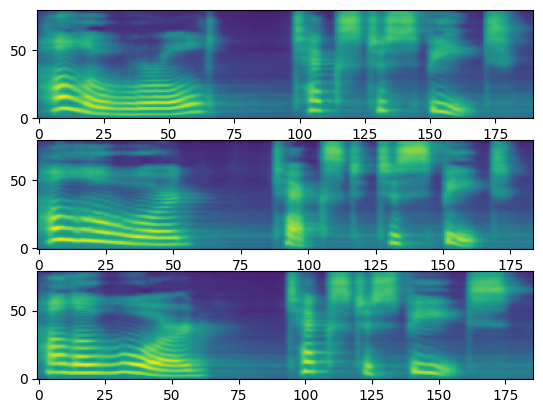

In [10]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        # spec[0]은 배치의 첫 번째 샘플에 해당하며, detach()는 그래디언트 계산에서 분리.
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [29]:
!pip install yt_dlp

In [36]:
from IPython.display import Image, display, Markdown

# 비디오 ID와 썸네일 URL을 설정합니다.
video_id = 'i7AUMU-GDNg'
thumbnail_url = f'https://img.youtube.com/vi/{video_id}/maxresdefault.jpg'

# 마크다운 문자열을 생성
markdown_text = f"""
# 로제-On The Ground 가사 추론해보기
![Thumbnail]({thumbnail_url})

[비디오 링크](https://www.youtube.com/watch?v={video_id})
"""

# 마크다운을 노트북에 표시
display(Markdown(markdown_text))



# 로제-On The Ground 가사 추론해보기
![Thumbnail](https://img.youtube.com/vi/i7AUMU-GDNg/maxresdefault.jpg)

[비디오 링크](https://www.youtube.com/watch?v=i7AUMU-GDNg)


In [40]:
import yt_dlp
from pydub import AudioSegment
from IPython.display import Audio, display

# 유튜브 비디오 URL
video_url = 'https://www.youtube.com/watch?v=AvrT2DMM4k4'

# yt-dlp 옵션 설정
ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': 'audio.%(ext)s',
    'postprocessors': [({
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    })],
}

# 오디오 다운로드
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(video_url, download=True)
    audio_file = 'audio.mp3'

# 다운로드된 오디오
audio = AudioSegment.from_mp3(audio_file)

# 오디오의 처음 30초 (주석처리됨)
# audio_30s = audio[:30000]  # 30000ms = 30초

# 잘라낸 오디오를 파일로 저장 (주석처리됨)
# audio_30s_file = 'audio_30s.mp3'
# audio_30s.export(audio_30s_file, format='mp3')

# 전체 오디오 파일을 저장 (수정된 부분)
audio.export('audio_exported.mp3', format='mp3')

# Jupyter Notebook에 재생 가능한 오디오 버튼 추가
display(Audio('audio_exported.mp3'))


[youtube] Extracting URL: https://www.youtube.com/watch?v=AvrT2DMM4k4
[youtube] AvrT2DMM4k4: Downloading webpage
[youtube] AvrT2DMM4k4: Downloading ios player API JSON
[youtube] AvrT2DMM4k4: Downloading web creator player API JSON
[youtube] AvrT2DMM4k4: Downloading m3u8 information
[info] AvrT2DMM4k4: Downloading 1 format(s): 251
[download] Destination: audio.webm
[download] 100% of    2.67MiB in 00:00:00 at 9.43MiB/s     
[ExtractAudio] Destination: audio.mp3
Deleting original file audio.webm (pass -k to keep)


In [17]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
# 학습에 사용된 데이터 셋: https://keithito.com/LJ-Speech-Dataset/

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

'''로제 On The Ground 가사를 추론하기 '''
'''================================'''

text = """I worked my whole life
Just to get right, just to be like
"Look at me, I'm never coming down"
I worked my whole life
Just to get high, just to realize
Everything I need is on the
Everything I need is on the ground
"""

'''================================'''

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

c:\Users\hopio\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


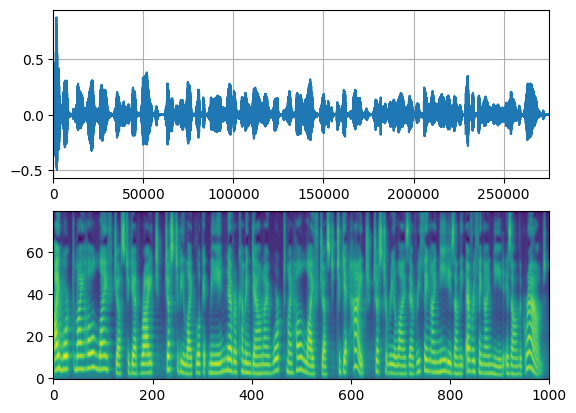

In [18]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

## basic-TTS is overed!!
텍스트를 입력 받으면 음성으로 추론을 하는 TTS를 배워봤습니다.

[다음은 코스는 목소리를 다른 목소리로 교체하는 STS를 코드로 직접 구현해 보겠습니다.]()